# PyTorch Transfer Learning

Transfer learning is the usage of models that have been trained on general data to solve a more specific problem.  
PyTorch offers pre-trained models in `torchvision.models`, `torchtext.models`, `torchaudio.models`, and `torchrec.models`.  
Models can also be found on HuggingFace, `timm`, and Paperswithcode.

## Setup

In [1]:
import torch
import torchvision

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.1.2
0.16.2


In [3]:
import matplotlib.pyplot as plt

In [4]:
from torch import nn
from torchvision import transforms

In [5]:
try:
    from torchinfo import summary
except:
    print("[INFO] Could not find torchinfo, installing")
    !pip install -q torchinfo
    from torchinfo import summary

In [6]:
try:
    from going_modular.going_modular import data_setup, engine
except:
    print("[INFO] Could not find going_modular scripts, installing")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Get datas

In [8]:
import os
import zipfile
import requests

In [9]:
from pathlib import Path

In [10]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
if image_path.is_dir():
    print(f"{image_path} exists")
else:
    print(f"Could not find {image_path}, creating")
    image_path.mkdir(parents=True, exist_ok=True)
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data")
        f.write(request.content)
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping data")
        zip_ref.extractall(image_path)
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi exists


In [11]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create Datasets and DataLoaders

The data going into a pre-trained model is expected to fit certain standards, which is achieved by applying the relevant transforms.  
The data has to be in form of mini-batches of data of shape `3 x H x W`, where `H` and `W` each have to be at least `224`.  
Each value has to be in the range `[0, 1]`, with mean `[0.485, 0.456, 0.406]` and standard deviation `[0.229, 0.224, 0.225]`.

The first approach is to manually create a transform that fits the given requirements.

In [12]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

The second approach is to automatically create the transform from the model weights we would like to use.

In [13]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)

## Using EfficientNet

In [15]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

EfficientNet consists of three sections.  
`features` is a group of convolutional and activation layers that learn a base representation of the vision data.  
`avgpool` takes the average of the output of the `features` layer and turns it into a features vector.  
`classifier` turns the feature vector into a vector of the same dimensionality as the number of classes (by default `1000` classes).

In [16]:
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

We freeze all base layers in the `features` section of the model.

In [17]:
for param in model.features.parameters():
    param.requires_grad = False

The `classifier` section is modified to have `3` output nodes instead of `1000`.

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = len(class_names)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)

In [19]:
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Training the model

In [20]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [22]:
from timeit import default_timer as timer

In [23]:
start_time = timer()
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)
end_time = timer()
print(f"[INFO] Total training time: {(end_time - start_time):.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Total training time: 413.332 seconds


## Evaluating results

In [24]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Could not find helper functions, downloading")
    with open("helper_functions.py", "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

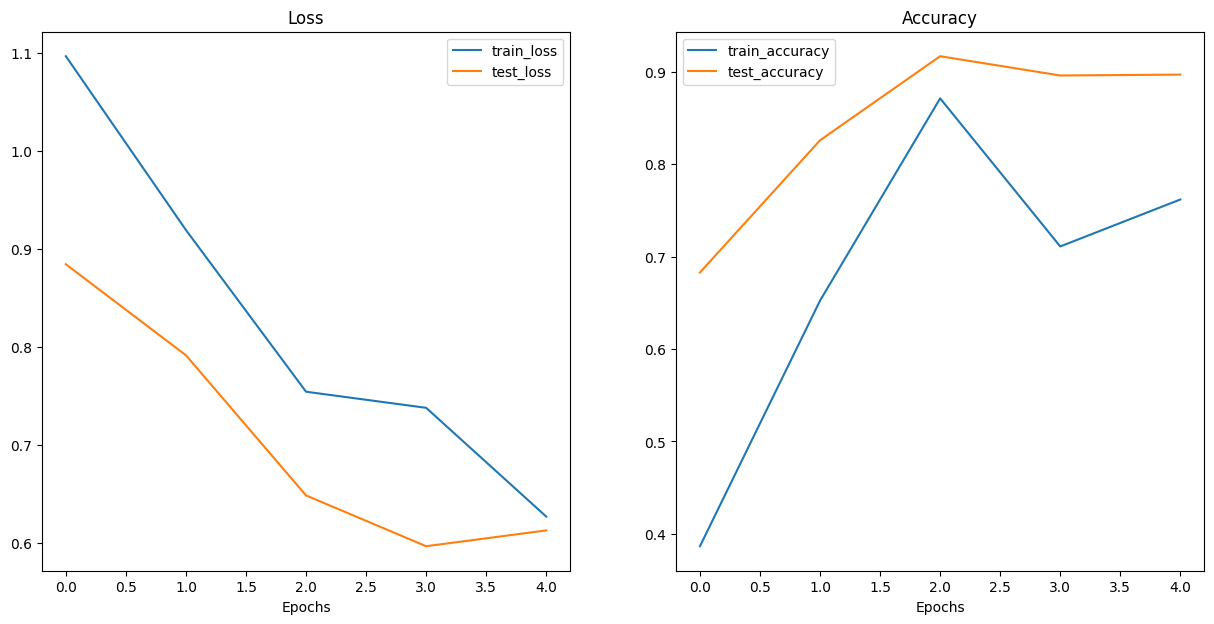

In [25]:
plot_loss_curves(results)

## Making predictions on random images

In [26]:
from typing import List, Tuple
from PIL import Image

In [27]:
def pred_and_plot(
        model: torch.nn.Module,
        image_path: str,
        class_names: List[str],
        image_size: Tuple[int, int] = (224, 224),
        transform: torchvision.transforms = None,
        device: torch.device = device
):
    img = Image.open(image_path)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0).to(device)
        target_image_pred = model(transformed_image)
        target_image_pred_probs = target_image_pred.softmax(dim=1)
        target_image_pred_label = target_image_pred_probs.argmax(dim=1)
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
        plt.axis(False)

In [28]:
import random

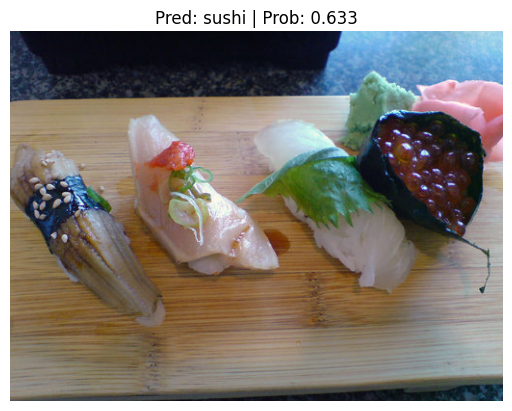

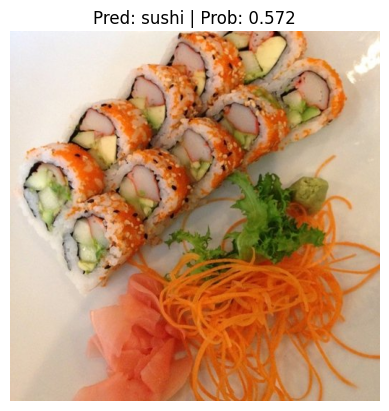

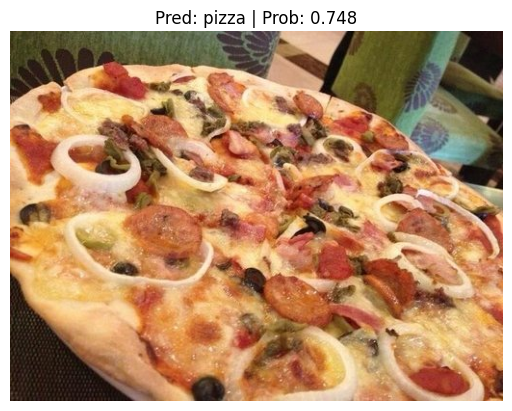

In [29]:
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)
for image_path in test_image_path_sample:
    pred_and_plot(model=model, image_path=image_path, class_names=class_names, image_size=(224, 224))

In [30]:
custom_image_path = data_path / "04-pizza-dad.jpeg"
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists")

data/04-pizza-dad.jpeg already exists


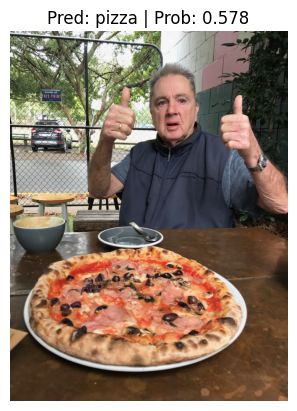

In [31]:
pred_and_plot(model=model, image_path=custom_image_path, class_names=class_names)